# **Atakeen sailkapena konputagailuen arteko komunikazioetan grafo egiturak erabiliz, datu-multzoa handituz**

Beharko ditugun liburutegiak:

In [3]:
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn import metrics, linear_model
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import fractional_matrix_power
import csv
from torch_geometric.data import Data
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import MessagePassing
import math
import random

Instalatu beharrekoak:

In [ ]:
!pip install torch_geometric
!pip install pandas
!pip install numpy
!pip install scipy==1.8.0
!pip install networkx

## **Datuak kargatzen**

Erabili diren datuak drive-n gorde dira, eta beraz, bertatik kargatuko dira.

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## **CSV-ak irakurri eta bakar batean elkartu**

BETH datu-multzoa CSV desberdinetan banatuta dago. Beraz, taula hauek batean batu behar dira.

In [5]:
path = '/content/drive/MyDrive/GrAL/DATUAK/ELKARTZEKO'
files = [os.path.join(path, file) for file in os.listdir(path)]
taula = pd.concat(map(pd.read_csv, files), ignore_index=True)
originala = pd.concat(map(pd.read_csv, files), ignore_index=True)

##**CSV-a moldatu**

Bi taula desberdin erabiliko dira, taula originala, aldaketarik gabekoa, eta moldatutako taula, honek datuak aurreprozesatuta gordeko ditu.

In [6]:
taula = taula[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]
originala = originala[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]


# Preprocessing
taula["processId"] = taula["processId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["parentProcessId"] = taula["parentProcessId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["userId"] = taula["userId"].map(lambda x: 1 if x < 1000 else 0)
taula["eventId"] = taula["eventId"]
taula["argsNum"] = taula["argsNum"]
taula["returnValue"] = taula["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


# CSV berriak sortu
taula.to_csv('dataset.csv')
originala.to_csv('orig_dataset.csv')

## **Sailkapenak egiteko erabiliko diren ezaugarrien zerrenda prestatzeko**

Lehendabizi, aurretik prestatutako taula berriak irakurriko dira.

In [7]:
# Aurre-prozesatua
with open('/content/dataset.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]

# Originala
with open('/content/orig_dataset.csv',newline='') as f:
    r2 = csv.reader(f)
    data_orig = [line for line in r2]

Ondoren, ezaugarrien zerrenda prestatuko da.

In [8]:
# EZAUGARRIEN ZERRENDA
max = 9000
kop = 0
nodoak = []
ezaugarriak = []
ertzak = []
unekoGur = ""
unekoUm = ""
ertzaGehitu = True

for i in range(1, len(data_orig)):

  ertzaGehitu = True

  # PROZESU GURASOA
  # Ez bada prozesu gurasoaren identifikatzailea nodoak zerrendan txertatu
  if not int(data_orig[i][2]) in nodoak:
    nodoak.append(int(data_orig[i][2]))
    ezaugarriak.append([-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, 0.0, kop])   # "-inf"-ekin erabili ostian, erroreak NaN delako infinito, visualize egitean erroreak.
    unekoGur = kop
    kop = kop+1
  else:     # Prozesu gurasoaren identifikatzailea nodoak zerrendan badago
    ind = nodoak.index(int(data_orig[i][2]))
    unekoGur = ezaugarriak[ind][7]

  # PROZESU UMEA
  # Dagoeneko existitzen bada prozesu umea nodoak zerrendan
  if int(data_orig[i][1]) in nodoak:
    ind = nodoak.index(int(data_orig[i][1]))

    if (ezaugarriak[ind][1]==-1000.0):      # Nodoak ez du ezaugarririk prozesu gurasoa izan delako. Ezaugarriak eguneratu beharko dira.
      unekoUm = ezaugarriak[ind][7]
      ezaugarriak[ind][0] = float(data[i][1])
      ezaugarriak[ind][1] = float(data[i][2])
      ezaugarriak[ind][2] = float(data[i][3])
      ezaugarriak[ind][3] = float(data[i][4])
      ezaugarriak[ind][4] = float(data[i][5])
      ezaugarriak[ind][5] = float(data[i][6])
      ezaugarriak[ind][6] = float(data[i][7])
    else:
      if (float(data[i][7]) == 1):          # Prozesua erasotzailea da
        nodoak.append(kop)
        ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
        unekoUm = kop
        # Ausazko ertzak sortzeko
        zenbat = random.randint(0, 10)
        for i in range(0, zenbat):
          zein = random.randint(0, 19031-1)
          if (random.randint(0,1) == 0):
            ertzak.append([unekoUm, zein])
          else:
            ertzak.append([zein, unekoUm])
        kop = kop+1

      else:           # Prozesua ez da erasotzailea
        if max>0:
          nodoak.append(kop)
          ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
          unekoUm = kop
          max = max-1
          # Ausazko ertzak sortzeko
          zenbat = random.randint(0, 10)
          for i in range(0, zenbat):
            zein = random.randint(0, 19031-1)
            if (random.randint(0,1) == 0):
              ertzak.append([unekoUm, zein])
            else:
              ertzak.append([zein, unekoUm])
          kop = kop+1
        else:
          ertzaGehitu = False

  else:
    nodoak.append(int(data_orig[i][1]))
    ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
    unekoUm = kop
    kop = kop+1


  if ertzaGehitu:
    ertzak.append([unekoGur, unekoUm])


_________________________________________________________________________________________________________

# **`Data` motako objektua sortzen**

#### **x lortzeko**
Grafoaren ezaugarri-matrizea da (hau da, grafoaren nodo bakoitzeko ezaugarriez osatutako zutabeak dituen matrizea).

**shape** `[num_nodes, num_node_features]`

In [9]:
x = []
for i in range(0,len(ezaugarriak)):
  x.append([ezaugarriak[i][0], ezaugarriak[i][1], ezaugarriak[i][2], ezaugarriak[i][3], ezaugarriak[i][4], ezaugarriak[i][5]])

In [10]:
scaler = MinMaxScaler()
new_x = scaler.fit_transform(x)
x = torch.tensor(new_x, dtype=torch.float)
x.size()

torch.Size([19032, 6])

#### **edge_index lortzeko**
Grafoaren konektibitate-matrizea da, COO formatuan. Konektatuta dauden nodoen zerrenda bakarrik gordetzen da, grafoaren auzokide matrize osoa gorde beharrean.

**shape** `[2, num_edges]`

In [11]:
# edge_index tensore bat denez, eraldatu
matrix = np.transpose(ertzak)
matrix = np.vstack(matrix).astype(np.intc)

edge_index = torch.tensor(matrix)
edge_index.size()

torch.Size([2, 115049])

#### **y lortzen**
Nodo bakoitzaren etiketa-matrizea da (bi klasetatik nodo bakoitza zeini dagokion adieraziko du).

In [12]:
y = []
for i in range(0,len(ezaugarriak)):
  y.append(int(ezaugarriak[i][6]))

y = torch.tensor(y)

In [13]:
# Zenbat nodo erasotzaile dauden guztira eta indizeak
kont = 0
indizeak = []
for k in range(0, len(y)):
  if (y[k]==1):
    indizeak.append(k)
    kont = kont+1

print("Kopurua: ", kont)
print("Indizeak: ", indizeak)

Kopurua:  10005
Indizeak:  [9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9077, 9078, 9079, 9080, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 

#### **Data objektua sortzeko**

In [14]:
# Data objektua sortzeko
data = Data(x=x, edge_index=edge_index, y=y)

In [15]:
# train_mask lortzeko
# Entrenamendu-multzoan dataseteko zein nodo dauden adierazten duen matrize bitarra da.
a = np.zeros(4513)
b = np.ones(4513)
c = np.zeros(3100)
d = np.ones(6906)
data.train_mask = torch.tensor(np.concatenate((a,b,c,d)), dtype=torch.bool)

# test_mask lortzeko
# Proba-multzoan dataseteko zein nodo dauden adierazten duen matrize bitarra da.
e = np.ones(4513)
f = np.zeros(4513)
g = np.ones(3100)
h = np.zeros(6906)
data.test_mask = torch.tensor(np.concatenate((e,f,g,h)), dtype=torch.bool)

In [16]:
# Data objektuaren ezaugarriak
print("Nodoen ezaugarri kopurua: ", data.num_features)
print("Data: ", data)
print("Nodo kopurua: ", data.num_nodes)
print("Ertz kopurua: ", data.num_edges)

Nodoen ezaugarri kopurua:  6
Data:  Data(x=[19032, 6], edge_index=[2, 115049], y=[19032], train_mask=[19032], test_mask=[19032])
Nodo kopurua:  19032
Ertz kopurua:  115049


## **GCN EREDUA**

GCN eredua sortzen da, lau GCNConv geruzarekin.

In [17]:
class GCN(MessagePassing):

    def __init__(self, hidden_channels, num_features, num_classes):
        # __init__()-en, klase nagusira deitu behar da bigarren klaseari esleipenak egin aurretik.
        super().__init__()

        # Ausazko zenbakiak sortzeko hazia ezartzen du. torch.Generator motako objektua itzultzen du.
        # PyTorchen ausazkotasuna kontrolatzen laguntzen duen funtzioa da.
        torch.manual_seed(42)

        # INITIALIZING THE LAYERS
        # Lehenengo, GCN geruza kopurua definitzen da.
        # Kasu honetan, Message Passing-a burutzeko lau geruza ditu.
        # GCN layers (message passing layers)
        self.conv1 = GCNConv(num_features, hidden_channels)     # Lehenengo geruza
        self.conv2 = GCNConv(hidden_channels, hidden_channels)      # Bigarren geruza
        self.conv3 = GCNConv(hidden_channels, hidden_channels)      # Hirugarren geruza
        self.conv4 = GCNConv(hidden_channels, hidden_channels)      # Laugarren geruza

        # Transformazio lineal bakarra aplikatzen da (torch.nn.Linear), eta honek, sailkatzaile gisa jarduten du (nodoak 0 edo 1 klasean sailkatzeko).
        # Output layer, sailkatzailea
        self.out = Linear(hidden_channels, num_classes)


    # Sarearen konputazio-fluxua definitzeko (forward)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()      # Lehenengo Message Passing Layer
        h = self.conv2(h, edge_index).relu()      # Bigarren Message Passing Layer
        h = self.conv3(h, edge_index).relu()      # Hirugarren Message Passing Layer
        h = self.conv4(h, edge_index).relu()      # Laugarren Message Passing Layer
        out = self.out(h)
        return out, h


In [18]:
# num_features --> Nodoen ezaugarri kopurua (data.num_features)
# num_classes = 2 (Erasoa edo ez, hau da, nodo bat erasotzailea den edo ez)
# Ereduak 16 kanal ezkutu izango ditu.
model = GCN(hidden_channels=16, num_features=6, num_classes=2)

# Sare-arkitektura definitzeaz gain, CrossEntropyLoss funtzioa definitzen da, eta Adam optimizatzailea hasieratzen da.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():

      # model.train() funtzioak, eredua entrenatzen ari dela adierazten du, hau da, ez du eredua entrenatzen, baizik eta modua ezartzen du. Honek, Dropout
      # eta BatchNorm bezalako geruzak informatzen laguntzen du, entrenamenduan eta ebaluazioan desberdin jokatzeko diseinatuta baitaude.
      model.train()

      for epoch in range(10):
        optimizer.zero_grad()  # Gradienteak zeroan jarri
        out, h = model(data.x, data.edge_index)  # Forward urrats bat aurrera
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Galera kalkulatzen da soilik entrenamendu-nodoetan oinarrituta
        loss.backward()  # Gradienteak deribatu
        optimizer.step()  # Gradienteetan oinarritutako parametroak eguneratzen dira

      pred = out.argmax(dim=1)  # Probabilitate handiena duen klasea erabiltzen da
      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

      return pred[data.train_mask], data.y[data.train_mask], train_correct.sum(), train_acc

def test():
      model.eval()      # model.eval() erabiltzean ereduari adierazten zaio ez dela ezer berririk ikasi behar, eta eredua probatzeko erabiltzen da.
      out, h = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Probabilitate handiena duen klasea erabiltzen da
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Ongi sailkatutako nodo kopurua
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Accuracy-a
      return pred[data.test_mask], data.y[data.test_mask], test_correct.sum(), test_acc

#### **TRAIN**

In [19]:
# Eredua entrenatzen da
pred, actual, train_correct, train_acc = train()

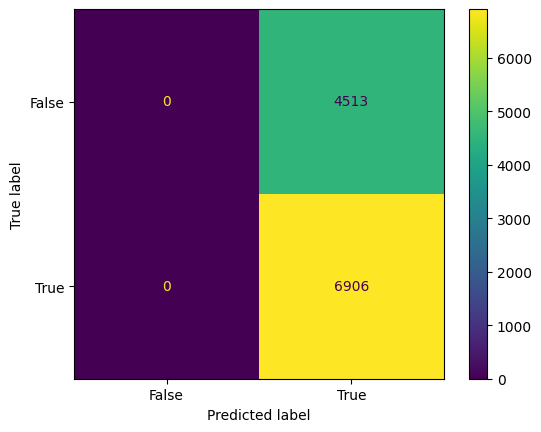

In [20]:
# Entrenamenduaren konfusio-matrizea
# True Negative (Top-Left Quadrant)
# False Positive (Top-Right Quadrant)
# False Negative (Bottom-Left Quadrant)
# True Positive (Bottom-Right Quadrant)

confusion_matrix = metrics.confusion_matrix(actual, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
# Precision balioek adierazten dute negatibotzat, edo 0 klasean, sailkatu diren datuen artetik zenbat sailkatu direla ondo, eta positibotzat, edo 1 klasean,
# sailkatu diren datuen artetik zenbat sailkatu direla ondo.
metrics.precision_score(actual, pred, average=None)

array([0.       , 0.6047815])

In [ ]:
# Recall balioek adierazten dute ereduak egiazko negatiboak eta egiazko positiboak identifikatzeko gaitasuna.
metrics.recall_score(actual, pred, average=None)

array([0., 1.])

In [ ]:
# F1 balioak
metrics.f1_score(actual, pred, average=None)

array([0.        , 0.75372442])

#### **TEST**

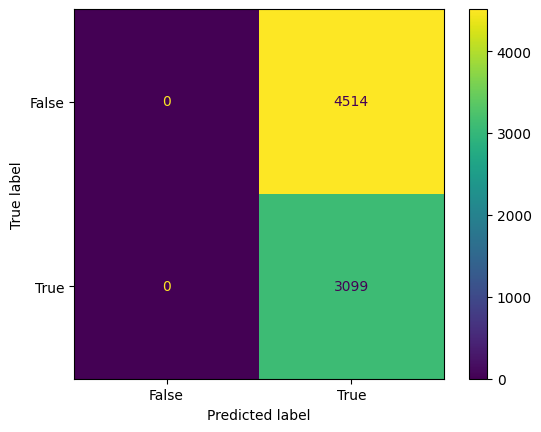

In [ ]:
# Eredua probatzen da
pred, actual, test_correct, test_acc = test()

# Test-aren konfusio-matrizea
confusion_matrix = metrics.confusion_matrix(actual, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
# Precision balioak
metrics.precision_score(actual, pred, average=None)

array([0.        , 0.40706686])

In [ ]:
# Recall balioak
metrics.recall_score(actual, pred, average=None)

array([0., 1.])

In [ ]:
# F1 balioak
metrics.f1_score(actual, pred, average=None)

array([0.        , 0.57860344])